In [16]:
#3(b)
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from networkie.gen import Custom
from networkie.utils import Measures
lff = Custom.LoadFromFile()
g = lff.from_in_class_network('dataset/In-class_network.txt')

In [17]:
#3(b)
print('(i) the number of nodes n: ',g.order())
        
print('(ii) the number of edges e: ',g.size())

degrees = g.degree() 
avg_degree = np.mean(list(dict(degrees).values()))
print('(iii) average degree <k>: ',avg_degree)

num=0
total_length=0
for i in g.nodes():
    s=range(i+1,len(g.nodes()))
    for j in s:
        if nx.has_path(g,i,j):
            total_length+=nx.shortest_path_length(g,i,j)
            num+=1
print('(iv) average path length l: ',total_length/num)

cc = nx.connected_components(g)
largest_cc = len(max(nx.connected_components(g), key=len))       
print('(v) the size of the largest connected component nG: ',largest_cc)


(i) the number of nodes n:  75
(ii) the number of edges e:  109
(iii) average degree <k>:  2.9066666666666667
(iv) average path length l:  4.508474576271187
(v) the size of the largest connected component nG:  45


In [18]:
#3(c)
e_max=len(g.nodes())*(len(g.nodes())-1)/2
print('e/emax: ',g.size()/e_max)

e/emax:  0.03927927927927928


Text(0,0.5,'degrees')

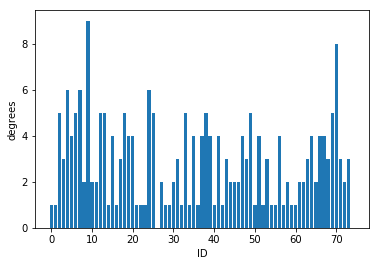

In [19]:
Node= Measures.Node()
l=Node.degree_dist(g)
indexes=[]
for i in range(len(g.nodes())):
    indexes.append(i)

plt.bar(indexes, l)
plt.xlabel('ID')
plt.ylabel('degrees')

In [20]:
#6(a)
def potential_friends():
    potential_friends=[]
    for i in g.nodes():
        x=list(g.neighbors(i))
        l=[]
        for j in x:
            l.extend(list(g.neighbors(j)))
        y=set(l)
        if len(l)!=0:
            y.discard(i)
            for k in x:
                y.discard(k)
            
        potential_friends.append(y)
    return potential_friends



potential_friends=potential_friends()

mutual_friends=[]
for i in range(len(g.nodes())):
    x=list(g.neighbors(i))
    l1={}
    for j in potential_friends[i]:
        y=list(g.neighbors(j))
        l2=[]
        for k in x:
            if k in y:
                l2.append(k)
        l1[j]=(len(l2))
    mutual_friends.append(l1)

potential_friends_45=[]
for j in range(3):
    num=0
    potential_friends_45.append('')
    for i in mutual_friends[45]:
        if i in potential_friends_45:
            continue
        if mutual_friends[45][i]>num:
            potential_friends_45[j]=i
            num=mutual_friends[45][i]

In [21]:
print('suggest 3 new friends to 45',potential_friends_45)

suggest 3 new friends to 45 [56, 57, 34]
